## Universal Style Transfer
The models above are trained to work for a single style. Using these methods, in order to create a new style transfer model, you have to train the model with a wide variety of content images.

Recent work by Yijun Li et al. shows that it is possible to create a model that generalizes to unseen style images, while maintaining the quality of output images.

Their method works by treating style transfer as an image reconstruction task. They use the output of a VGG19 ReLU layer to encode features of various content images and traing a decoder to reconstruct these images. Then, with these two networks fixed, they feed the content and the style image into the encoder and use a whitening and coloring transform so that the covarience matrix of the features matches the covarience matrix of the style.

This process can then be expanded to the remaining ReLU layers of VGG19 to create a style transfer pipeline that can apply to all spatial scales.

Since only content images were used to train the encoder and decoder, additional training is not needed when generalizing this to new styles.

<img src="images/universal-style-transfer.png" style="width: 600px;"/>
(Yijun Li et al., Universal Style Transfer)

<img src="images/doge_the_scream.jpg" style="width: 300px;"/>
<img src="images/doge_mosaic.jpg" style="width: 300px;"/>

The results are pretty impressive, but there are some patches of blurriness, most likely as a result of the transforms.

### Whitening Transform

The whitening transform removes the style from the content image, keeping the global content structure.

The features of the content image, $f_c$, are transformed to obtain $\hat{f}_c$, such that the feature maps
are uncorrelated ($\hat{f}_c \hat{f}_c^T = I$),

$$
    \hat{f}_c = E_c D_c^{- \frac{1}{2}} E_c^T f_c
$$

where $D_c$ is a diagonal matrix with the eigenvalues of the covariance matrix $f_c f_c^T \in R^{C \times C}$,
and $E_c$ is the corresponding orthogonal matrix of eigenvectors, satisfying $f_c f_c^T = E_c D_c E_c^T$.

<img src="images/whitening.png" style="width: 300px;"/>
(Yijun Li et al., Universal Style Transfer)


### Coloring Transform

The coloring transform adds the style from the style image onto the content image.

The whitening transformed features of the content image, $\hat{f}_c$, are transformed to obtain $\hat{f}_{cs}$, such that the feature maps have that desired correlations ($\hat{f}_{cs} \hat{f}_{cs}^T = f_s f_s^T$),

$$
    \hat{f}_{cs} = E_s D_s^{\frac{1}{2}} E_s^T \hat{f}_c
$$

where $D_s$ is a diagonal matrix with the eigenvalues of the covariance matrix $f_s f_s^T \in R^{C \times C}$,
and $E_s$ is the corresponding orthogonal matrix of eigenvectors, satisfying $f_c f_c^T = E_c D_c E_c^T$.

In practice, we also take a weighted sum of the colored and original activations such that:

$$ f_{blend} = \alpha\hat{f}_{cs} + (1-\alpha)\hat{f}_c $$ 

Before each transform step, the mean of the corresponding feature maps are subtracted, and the mean of the style features are added back to the final transformed features.

In [1]:
# workaround for multiple OpenMP on Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
from pathlib import PurePath

import IPython.display as display
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title==None:
        title = str(image.shape)
    else:
        title += ' '+str(image.shape)
    plt.title(title)

# Using a pre-trained AutoEncoder
For this assignment, i will be using an auto encoder created with Yihao Wang, a PhD student in the UbiComp lab here at SMU. The original code used to created this encoder is available for SMU students. 

The model that was trained can be downloaded from:
https://www.dropbox.com/sh/2djb2c0ohxtvy2t/AAAxA2dnoFBcHGqfP0zLx-Oua?dl=0 

In [3]:
class VGG19AutoEncoder(tf.keras.Model):
    def __init__(self, files_path):
        super(VGG19AutoEncoder, self).__init__()
        #Load Full Model with every trained decoder
        
        
        #Get Each SubModel
        # Each model has an encoder, a decoder, and an extra output convolution
        # that converts the upsampled activations into output images
        
        # DO NOT load models four and five because they are not great auto encoders
        # and therefore will cause weird artifacts when used for style transfer 
        
        ModelBlock3 = tf.keras.models.load_model(str(PurePath(files_path, 'Block3_Model')), compile = False)
        self.E3 = ModelBlock3.layers[0] # VGG encoder
        self.D3 = ModelBlock3.layers[1] # Trained decoder from VGG
        self.O3 = ModelBlock3.layers[2] # Conv layer to get to three channels, RGB image
        
        ModelBlock2 = tf.keras.models.load_model(str(PurePath(files_path, 'Block2_Model')), compile = False)
        self.E2 = ModelBlock2.layers[0] # VGG encoder
        self.D2 = ModelBlock2.layers[1] # Trained decoder from VGG
        self.O2 = ModelBlock2.layers[2] # Conv layer to get to three channels, RGB image
        
        # no special decoder for this one becasue VGG first layer has
        # no downsampling. So the decoder is just a convolution 
        ModelBlock1 = tf.keras.models.load_model(str(PurePath(files_path, 'Block1_Model')), compile = False)
        self.E1 = ModelBlock1.layers[0] # VGG encoder, one layer
        self.O1 = ModelBlock1.layers[1] # Conv layer to get to three channels, RGB image
        
        
        

    def call(self, image, alphas=None, training  = False):
        # Input should be dictionary with 'style' and 'content' keys
        # {'style':style_image, 'content':content_image}
        # value in each should be a 4D Tensor,: (batch, i,j, channel)
        
        style_image = image['style']
        content_image = image['content']
        
        output_dict = dict()
        # this will be the output, where each value is a styled 
        # version of the image at layer 1, 2, and 3. So each key in the 
        # dictionary corresponds to layer1, layer2, and layer3.
        # we also give back the reconstructed image from the auto encoder
        # so each value in the dict is a tuple (styled, reconstructed)
        
        x = content_image
        # choose covariance function
        # covariance is more stable, but signal will work for very small images
        wct = self.wct_from_cov 
        
        if alphas==None:
            alphas = {'layer3':0.6, 
                      'layer2':0.6, 
                      'layer1':0.6}
        
        # ------Layer 3----------
        # apply whiten/color on layer 3 from the original image
        # get activations
        a_c = self.E3(tf.constant(x))
        a_s = self.E3(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(), a_s.numpy(), alpha=alphas['layer3'])
        # decode the new style
        x = self.O3(self.D3(x))
        x = self.enhance_contrast(x)
        # get reconstruction
        reconst3 = self.O3(self.D3(self.E3(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended3 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst3 = tf.clip_by_value(tf.squeeze(reconst3), 0, 1)
        output_dict['layer3'] = (blended3, reconst3)
        
        # ------Layer 2----------
        # apply whiten/color on layer 2 from the already blended image
        # get activations
        a_c = self.E2(tf.constant(x))
        a_s = self.E2(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer2'])
        # decode the new style
        x = self.O2(self.D2(x))
        x = self.enhance_contrast(x,1.3)
        # get reconstruction
        reconst2 = self.O2(self.D2(self.E2(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended2 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst2 = tf.clip_by_value(tf.squeeze(reconst2), 0, 1)
        output_dict['layer2'] = (blended2, reconst2)
        
        # ------Layer 1----------
        # apply whiten/color on layer 1 from the already blended image
        # get activations
        a_c = self.E1(tf.constant(x))
        a_s = self.E1(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer1'])
        # decode the new style
        x = self.O1(x)
        x = self.enhance_contrast(x,1.2)
        # get reconstruction
        reconst1 = self.O1(self.E1(tf.constant(content_image)))
        # save off the styled and reconstructed images for display
        blended1 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst1 = tf.clip_by_value(tf.squeeze(reconst1), 0, 1)
        output_dict['layer1'] = (blended1, reconst1)
           
        return output_dict

    @staticmethod
    def enhance_contrast(image, factor=1.25):
        return tf.image.adjust_contrast(image,factor)
        
    @staticmethod
    def wct_from_cov(content, style, alpha=0.6, eps=1e-5):
        '''
        https://github.com/eridgd/WCT-TF/blob/master/ops.py
           Perform Whiten-Color Transform on feature maps using numpy
           See p.4 of the Universal Style Transfer paper for equations:
           https://arxiv.org/pdf/1705.08086.pdf
        '''
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> CxH*W
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        # applt a threshold for only the largets eigen values
        eigen_val_thresh = 1e-5
        
        # ===Whitening transform===
        # 1. take mean of each channel
        mc = content_flat.mean(axis=1, keepdims=True)
        fc = content_flat - mc
        # 2. get covariance of content, take SVD
        cov_c = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
        Uc, Sc, _ = np.linalg.svd(cov_c)
        # 3. truncate the SVD to only the largest eigen values
        k_c = (Sc > eigen_val_thresh).sum()
        Dc = np.diag((Sc[:k_c]+eps)**-0.5)
        Uc = Uc[:,:k_c]
        # 4. Now make a whitened content image
        fc_white = (Uc @ Dc @ Uc.T) @ fc

        # ===Coloring transform===
        # 1. take mean of each channel
        ms = style_flat.mean(axis=1, keepdims=True)
        fs = style_flat - ms
        # 2. get covariance of style, take SVD
        cov_s = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
        Us, Ss, _ = np.linalg.svd(cov_s)
        # 3. truncate the SVD to only the largest eigen values
        k_s = (Ss > eigen_val_thresh).sum()
        Ds = np.sqrt(np.diag(Ss[:k_s]+eps))
        Us = Us[:,:k_s]
        # 4. Now make a colored image that mixes the Grammian of the style
        #   with the whitened content image
        fcs_hat = (Us @ Ds @ Us.T) @ fc_white
        fcs_hat = fcs_hat + ms # add style mean back to each channel

        # Blend transform features with original features
        blended = alpha*fcs_hat + (1 - alpha)*(content_flat) 

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)

    @staticmethod
    def wct_from_signal(content, style, alpha=0.6 ):
        # This uses a more computational SVD decomposition to get the Grammian
        # to match. However, the numerical precision makes this totally fail
        # if the activations are too large. 
        # This code is only for reference based on our discussion of WCT
        
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> Cx(H*W)
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        singular_val_thresh = 1e-3
        #-------------------------------------------
        # Whitening transform and Coloring transform
        # 1. SVD of content signals
        mc = content_flat.mean()
        fc = content_flat - mc
        Uc, Sc, Vc = np.linalg.svd(fc, full_matrices=False)
        k_c = (Sc > singular_val_thresh).sum()
        
        # 2. SVD of style signals
        ms = style_flat.mean()
        fs = style_flat - ms
        Us, Ss, Vs = np.linalg.svd(fs, full_matrices=False)
        k_s = (Ss > singular_val_thresh).sum()
        
        k = min(k_s,k_c)

        # Blend transform features with original features
        fcs = (Us[:,:k] @ np.diag(Ss[:k]) @ Vc[:k,:]) + mc
        blended = alpha*fcs + (1 - alpha)*(content_flat)

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)
    


In [5]:
%%time

AE = VGG19AutoEncoder('models/vgg_decoder/')

CPU times: total: 2.78 s
Wall time: 3.18 s


CPU times: total: 21.4 s
Wall time: 5.51 s


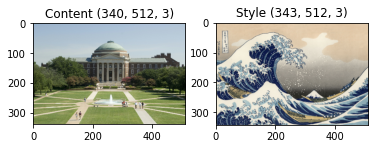

In [11]:
%%time

from skimage.transform import resize

content_path = 'images/dallas_hall.jpg'
style_path = 'images/wave_style.png'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image,'Content')

plt.subplot(1, 2, 2)
imshow(style_image,'Style')

tmp = {'style':style_image, 
       'content':content_image}

alphas = {'layer3':0.8, 'layer2':0.6, 'layer1':0.6}
decoded_images = AE(tmp, alphas=alphas)

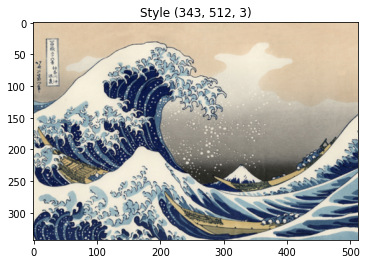

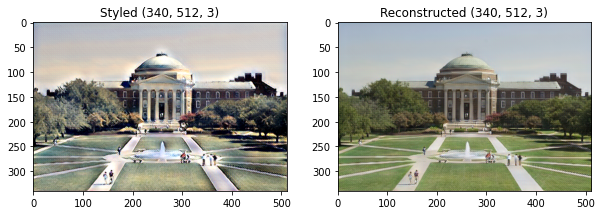

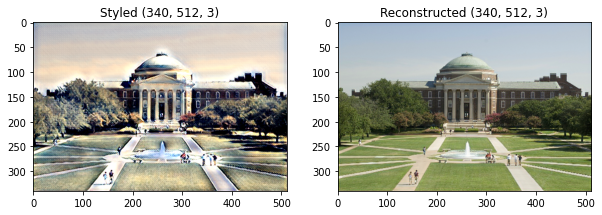

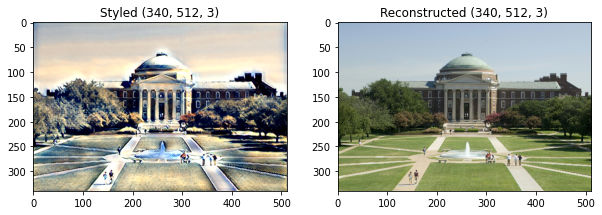

In [12]:
imshow(style_image,'Style')
for layer in decoded_images.keys():
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    imshow(decoded_images[layer][0],'Styled')
    plt.subplot(1,2,2)
    imshow(decoded_images[layer][1],'Reconstructed')